# Phase 3: Physics-Informed EDA

**Objective**: Validate the physical consistency of the cleaned "Silver" data.

**Key Physics Checks**:
1.  **Tensile Strength**: Is the distribution normal? (Formula: $\sigma = \frac{2F}{\pi D t}$)
2.  **Friction (Ejection)**: Are there sticking issues?
3.  **Viscoelasticity**: Does `Main Compression` scale with `Speed`?
4.  **Stationarity**: Check for drift in long batches.

In [1]:
import sys
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.config import get_boto3_client, BUCKET_SILVER

# Config
s3 = get_boto3_client()
PREFIX = "clean/"

sns.set(style="whitegrid")

🔌 S3 Client connecting to: http://minio:9000


## 1. Load Cleaned "Silver" Data
We load all available Parquet files from the Silver bucket.

In [2]:
def load_silver_data():
    files = []
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=BUCKET_SILVER, Prefix=PREFIX):
        if 'Contents' in page:
            for obj in page['Contents']:
                if obj['Key'].endswith('.parquet'):
                    files.append(obj['Key'])
    
    dfs = []
    for key in files:
        obj = s3.get_object(Bucket=BUCKET_SILVER, Key=key)
        with io.BytesIO(obj['Body'].read()) as f:
            df = pd.read_parquet(f)
            df['source_file'] = key
            dfs.append(df)
    
    if not dfs:
        print("No data found!")
        return pd.DataFrame()
        
    return pd.concat(dfs, ignore_index=True)

df = load_silver_data()
print(f"Loaded {len(df)} rows across {df['source_file'].nunique()} files.")
df.head()

Loaded 1161610 rows across 21 files.


,timestamp,campaign,batch,code,tbl_speed,fom,main_comp,tbl_fill,srel,pre_comp,produced,waste,cyl_main,cyl_pre,stiffness,ejection,diameter,source_file
0,2018-11-23 00:23:07+00:00,4,26,1,100.0,50.0,4.9,5.4,3.4,0.0,18.0,6619.0,1.8,5.0,4.0,187.0,6.07,clean/1.parquet
1,2018-11-23 00:23:17+00:00,4,26,1,100.0,50.0,5.0,5.4,4.1,0.0,18.0,6619.0,1.8,5.0,4.0,179.0,6.07,clean/1.parquet
2,2018-11-23 00:23:27+00:00,4,26,1,100.0,50.0,5.0,5.4,3.3,0.0,19.0,6619.0,1.8,5.0,4.0,178.0,6.07,clean/1.parquet
3,2018-11-23 00:23:37+00:00,4,26,1,100.0,50.0,4.9,5.4,3.9,0.0,19.0,6619.0,1.8,5.0,4.0,182.0,6.07,clean/1.parquet
4,2018-11-23 00:23:47+00:00,4,26,1,100.0,50.0,4.9,5.4,3.6,0.0,19.0,6619.0,1.8,5.0,4.0,182.0,6.07,clean/1.parquet


## 2. Calculate Dynamic Tensile Strength
We use the formula recovered in Phase 0:
$$ \sigma = \frac{2000 \cdot F}{\pi \cdot D \cdot t} $$
Where:
*   $F$ = `main_comp` (kN) -> Converted to N (x1000)
*   $D$ = `diameter` (mm)
*   $t$ = `cyl_main` (mm) - Proxy for tablet height/thickness

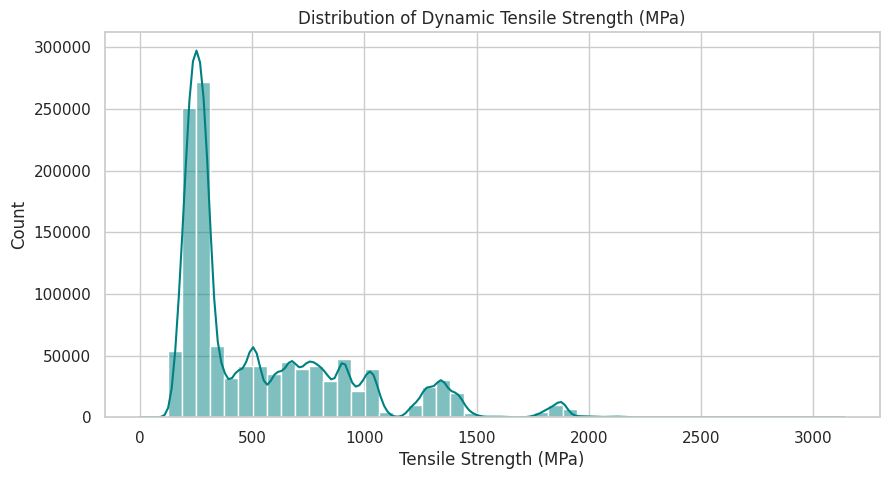

count    1.161577e+06
mean     5.343555e+02
std      3.906821e+02
min      0.000000e+00
25%      2.473087e+02
50%      3.149443e+02
75%      7.563799e+02
max      3.138186e+03
Name: tensile_strength, dtype: float64


In [6]:
# Ensure columns exist
required = ['main_comp', 'diameter', 'cyl_main']
missing = [c for c in required if c not in df.columns]
if missing:
    print(f"Missing columns: {missing}")
else:
    # Calculate
    # Note: cyl_main might be 0? Check.
    df = df[df['cyl_main'] > 0].copy()
    
    df['tensile_strength'] = (2 * df['main_comp'] * 1000) / (np.pi * df['diameter'] * df['cyl_main'])
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df['tensile_strength'], bins=50, kde=True, color='teal')
    plt.title("Distribution of Dynamic Tensile Strength (MPa)")
    plt.xlabel("Tensile Strength (MPa)")
    plt.show()
    
    print(df['tensile_strength'].describe())

## 3. Friction Analysis (Ejection Force)
High ejection force indicates "sticking" or low lubrication.
We investigate outliers.

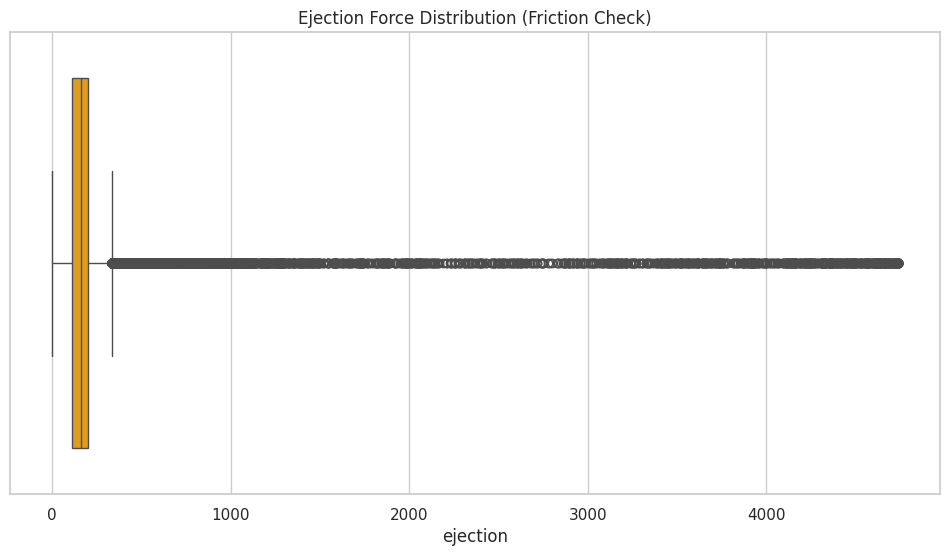

In [7]:
if 'ejection' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['ejection'], color='orange')
    plt.title("Ejection Force Distribution (Friction Check)")
    plt.show()

## 4. Viscoelasticity Check
In viscoelastic materials, Force increases with Strain Rate (Speed).
We expect a positive correlation between `tbl_speed` and `main_comp`.

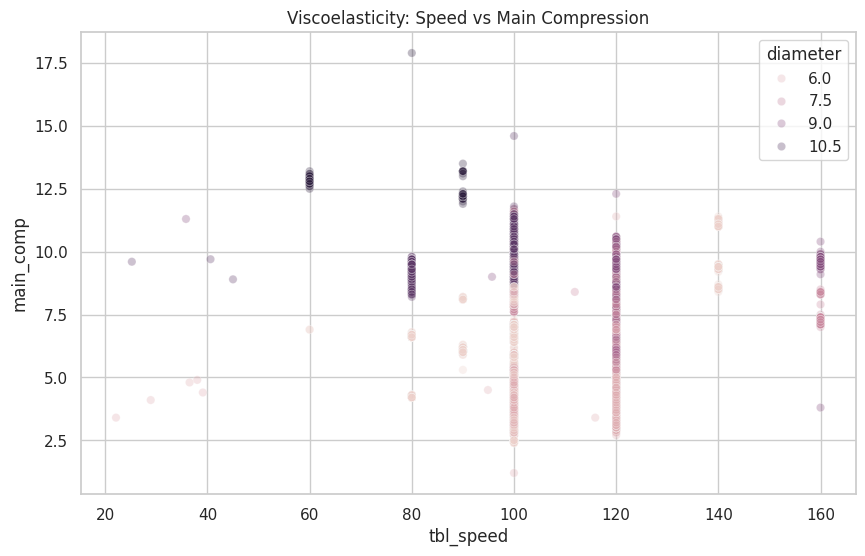

In [8]:
if 'tbl_speed' in df.columns and 'main_comp' in df.columns:
    # Sample for scatter plot performance
    sample = df.sample(min(10000, len(df)))
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=sample, x='tbl_speed', y='main_comp', alpha=0.3, hue='diameter')
    plt.title("Viscoelasticity: Speed vs Main Compression")
    plt.show()

## 5. Stationarity (Drift Analysis)
We pick one long batch and check for signal drift over time.

Analyzing largest batch: clean/22.parquet


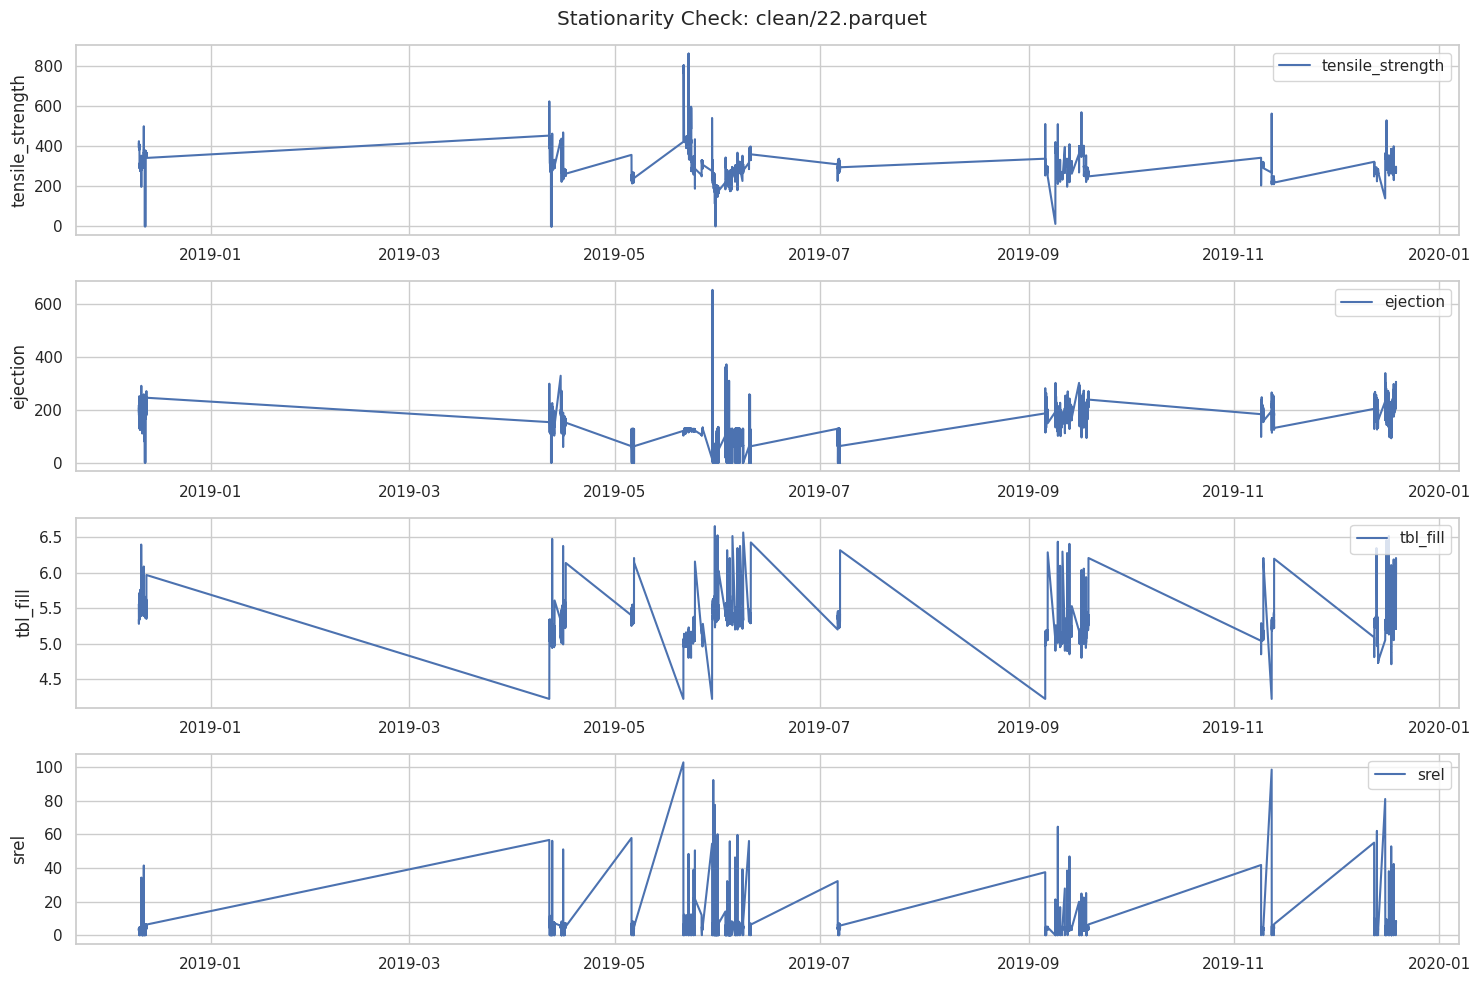

In [9]:
# Find largest file/batch
largest_file = df['source_file'].value_counts().idxmax()
print(f"Analyzing largest batch: {largest_file}")

batch_df = df[df['source_file'] == largest_file].sort_values('timestamp')

features = ['tensile_strength', 'ejection', 'tbl_fill', 'srel']
available = [f for f in features if f in batch_df.columns]

plt.figure(figsize=(15, 10))
for i, col in enumerate(available):
    plt.subplot(len(available), 1, i+1)
    plt.plot(batch_df['timestamp'], batch_df[col], label=col)
    plt.legend(loc='upper right')
    plt.ylabel(col)

plt.suptitle(f"Stationarity Check: {largest_file}")
plt.tight_layout()
plt.show()